# Example

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
% matplotlib inline
from subprocess import call, Popen, PIPE

from madminer import GoldMine, Smithy

## 1. Create GoldMine object

In [2]:
miner = GoldMine()

## 2. Define parameter space

In [3]:
miner.set_parameters()

miner.add_parameter(
    lha_block='ANOINPUTS',
    lha_id=3,
    parameter_name='fW',
    morphing_max_power=4,
    morphing_parameter_range=(-1.,1.)
)
miner.add_parameter(
    lha_block='ANOINPUTS',
    lha_id=7,
    parameter_name='fWW',
    morphing_max_power=4,
    morphing_parameter_range=(-1.,1.)
)

## 3. Define benchmark points (evaluation points for |M|^2)

### 3a. Set benchmarks by hand

In [4]:
miner.add_benchmark(
    {'fW':0., 'fWW':0.},
    'sm'
)

### 3b. Find good benchmarks for morphing

In [5]:
miner.set_benchmarks_from_morphing(keep_existing_benchmarks=True,
                                   n_bases=1,
                                   n_trials=100,
                                   n_test_thetas=100)

### Plot morphing basis and squared morphing weights (optional)

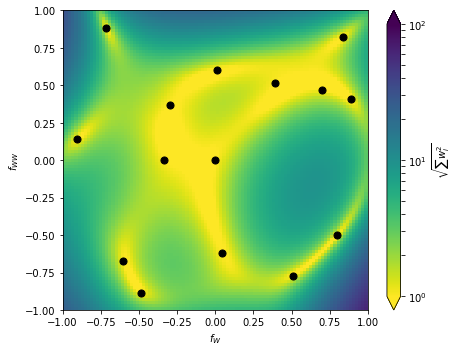

In [6]:
morpher = miner.morpher
basis = morpher.basis

xi, yi = np.linspace(-1.,1.,100), np.linspace(-1.,1.,100)
xx, yy = np.meshgrid(xi, yi)
xx, yy = xx.reshape((-1,1)), yy.reshape((-1,1))
theta_test = np.hstack([xx, yy])

squared_weights = []
for theta in theta_test:
    wi = morpher._calculate_morphing_weights(theta, None)
    squared_weights.append(np.sum(wi*wi)**0.5)
squared_weights = np.array(squared_weights).reshape((100,100))

fig = plt.figure(figsize=(6.5,5))
ax = plt.gca()

pcm = ax.pcolormesh(xi, yi, squared_weights,
                    norm=matplotlib.colors.LogNorm(vmin=1., vmax=1.e2),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(basis[:,0], basis[:,1], s=50., c='black')

plt.xlabel(r'$f_W$')
plt.ylabel(r'$f_{WW}$')
cbar.set_label(r'$\sqrt{\sum w_i^2}$')
plt.xlim(-1.,1.)
plt.ylim(-1.,1.)

plt.tight_layout()
plt.show()

## 4. Save settings

In [7]:
miner.save('data/madminer_example.h5')

## 5. Run MadGraph

In [ ]:
miner.run(
    mg_directory='/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2',
    proc_card_file='./templates/proc_card.dat',
    param_card_template_file='./templates/param_card_template.dat',
    reweight_card_template_file='./templates/reweight_card_template.dat',
    run_card_file='./templates/run_card.dat',
    sample_benchmark='sm',
    initial_command='source activate python2'
)

## 6. Run detector simulation and extract observables

To increase flexibility, this is not part of the madminer package. The delphesminer package includes the necessary steps based on Delphes

In [ ]:
from delphesminer import DelphesMiner
dm = DelphesMiner()

In [ ]:
dm.add_hepmc_sample('./MG_process/to/hepmc_events.hepmc')
dm.run_delphes('path/to/delphes_folder', 'path/to/delphes_card.dat', log_folder='.')

In [ ]:
dm.add_observable('j1_e', 'j[0].e')
dm.add_observable('n_jets', 'len(j)')
dm.add_observable('e1_eta', 'e[0].eta')
dm.add_observable('mu1_phi', 'mu[0].phi()')
dm.add_observable('met', 'met.pt')

dm.analyse_delphes_samples()

In [ ]:
dm.save('data/madminer_example_with_data.h5', 'data/madminer_example.h5')

## 7. Create Smithy object and load data

In [ ]:
smithy = Smithy('data/madminer_example_with_data.h5')